In [1]:
import os, shutil
import numpy

from obi_one.scientific.map_em_synapses import map_afferents_to_spiny_morphology, write_edges, write_nodes
from obi_one.scientific.map_em_synapses.map_synapse_locations import synapse_info_df
from obi_one.scientific.map_em_synapses.write_sonata_edge_file import _STR_PRE_NODE, _STR_POST_NODE
from obi_one.scientific.map_em_synapses.write_sonata_nodes_file import assemble_collection_from_specs

from neurom import load_morphology_with_spines

# INPUT
fn = "/Users/mwr/Documents/artefacts/neuron_meshes/skeletonized/864691135970442597.h5"

# CONFIGURATION
#  SONATA
out_root = "./sonata"
edge_population_name = "synaptome_afferents"
node_population_pre = "synaptome_afferent_neurons"
node_population_post = "biophysical_neuron"
#  CAVECLIENT
_version = 1507
_datastack_name = "minnie65_public"
_cave_client_url = "https://global.daf-apis.com"

# LOAD DATA
m = load_morphology_with_spines(fn, spines_are_centered=True)
pt_root_id = int(m.name)

# OUTPUTS
fn_edges_out = f"./{pt_root_id}-sonata_edges.h5"
fn_nodes_out = f"./{pt_root_id}-sonata_nodes.h5"
fn_morphology_out_h5 = os.path.join("morphologies", os.path.split(fn)[1])
os.makedirs(os.path.join(out_root, "morphologies/morphology"), exist_ok=True)
shutil.copy(fn, os.path.join(out_root, "morphologies"))
morphio_morph = m.to_morphio().as_mutable()
morphio_morph.soma.diameters += 1E-3
morphio_morph.write(os.path.join(out_root, "morphologies/morphology", m.name) + ".swc")


HDF5 GROUP:0:warning

Soma must be stacked cylinders or a point: see https://github.com/BlueBrain/MorphIO/issues/457


## Load afferent synapses using CAVEclient

In [2]:
from caveclient import CAVEclient

client = CAVEclient(_datastack_name, server_address=_cave_client_url)
client.version = _version
info = client._info.get_datastack_info()

syns = synapse_info_df(client, int(m.name), client.info.viewer_resolution(),
                       col_location="post_pt_position")

## Find locations of synapses on the morphology

In [3]:
mapped_synapses_df = map_afferents_to_spiny_morphology(m, syns)

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


## Write mapped synapses to SONATA edges

In [4]:
pre_pt_root_to_sonata = syns["pre_pt_root_id"].drop_duplicates().reset_index(drop=True).reset_index().set_index("pre_pt_root_id")
post_pt_root_to_sonata = syns["post_pt_root_id"].drop_duplicates().reset_index(drop=True).reset_index().set_index("post_pt_root_id")

syn_pre_post_df = pre_pt_root_to_sonata.loc[syns["pre_pt_root_id"]].rename(columns={"index": _STR_PRE_NODE})
syn_pre_post_df[_STR_POST_NODE] = 0
syn_pre_post_df = syn_pre_post_df.reset_index(drop=True)

write_edges(os.path.join(out_root, fn_edges_out), edge_population_name, syn_pre_post_df,
            mapped_synapses_df, node_population_pre, node_population_post)

## Load neuron info using CAVEclient
### Specify which information is needed and how it's formatted

In [5]:
specs = {
    "synapse_class": {
        "table": 'aibs_metamodel_mtypes_v661_v2',
        "column": 'classification_system',
        "default": "extrinsic_neuron"
    },
    "volume": {
        "table": 'aibs_metamodel_mtypes_v661_v2',
        "column": 'volume',
        "default": -1
    },
    "status_axon": {
        "table": 'proofreading_status_and_strategy',
        "column": 'status_axon',
        "default": "unknown"
    },
    "status_dendrite": {
        "table": 'proofreading_status_and_strategy',
        "column": 'status_dendrite',
        "default": "unknown"
    },
    "__position": {
        "table": 'aibs_metamodel_mtypes_v661_v2',
        "column": "pt_position",
        "resolution": {
            "x": info["viewer_resolution_x"] * 1E-3,
            "y": info["viewer_resolution_y"] * 1E-3,
            "z": info["viewer_resolution_z"] * 1E-3
        }
    }
}

### Assemble specified neuron information and write to nodes file

In [6]:
coll_pre = assemble_collection_from_specs(client, specs, pre_pt_root_to_sonata)
coll_post = assemble_collection_from_specs(client, specs, post_pt_root_to_sonata)

coll_post.properties["morphology"] = f"morphology/{m.name}"
write_nodes(os.path.join(out_root, fn_nodes_out), node_population_pre, coll_pre, write_mode="w")
write_nodes(os.path.join(out_root, fn_nodes_out), node_population_post, coll_post, write_mode="a")

In [7]:
sonata_cfg = {
  "components": {
    "biophysical_neuron_models_dir": "",
    "mechanisms_dir": "",
    "morphologies_dir": "",
    "point_neuron_models_dir": "",
    "synaptic_models_dir": "",
    "templates_dir": ""
  },
  "networks": {
    "edges": [
      {
        "edges_file": "$BASE_DIR/" + fn_edges_out,
        "populations": {
          edge_population_name: {
            "type": "chemical"
          }
        }
      }
    ],
    "nodes": [
      {
        "nodes_file": "$BASE_DIR/" + fn_nodes_out,
        "populations": {
          node_population_post: {
            "alternate_morphologies": {
              "h5v1": "$BASE_DIR/" + fn_morphology_out_h5
            },
            "biophysical_neuron_models_dir": "$BASE_DIR/emodels_hoc",
            "morphologies_dir": "$BASE_DIR/morphologies",
            "type": "biophysical"
          }
        }
      },
      {
        "nodes_file": "$BASE_DIR/" + fn_nodes_out,
        "populations": {
          node_population_pre: {
            "type": "virtual"
          }
        }
      }
    ]
  },
  "node_sets_file": "$BASE_DIR/node_sets.json",
  "version": 2.3,
  "manifest": {
    "$BASE_DIR": "./"
  }
}
with open(os.path.join(out_root, "circuit_config.json"), "w") as fid:
    import json
    json.dump(sonata_cfg, fid, indent=2)

In [8]:
import bluepysnap as snap

circ = snap.Circuit("sonata/circuit_config.json")

In [9]:
circ.nodes[node_population_pre].get()

,pt_root_id,status_axon,status_dendrite,synapse_class,volume,x,y,z
node_ids,,,,,,,,
0,864691135305110183,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00
1,864691135398733554,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00
2,864691134952719252,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00
3,864691135804846133,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00
4,864691135426135645,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00
...,...,...,...,...,...,...,...,...
3183,864691136388625527,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00
3184,864691136120512792,t,t,inhibitory_neuron,356.290724,753.728,695.424,771.80
3185,864691136905725362,unknown,unknown,extrinsic_neuron,-1.000000,-1.000,-1.000,-1.00


In [10]:
circ.nodes[node_population_post].get()

,morphology,post_pt_root_id,status_axon,status_dendrite,synapse_class,volume,x,y,z
node_ids,,,,,,,,,
0,morphology/864691135970442597,864691135970442597,t,t,excitatory_neuron,211.898204,720.384,455.232,884.72


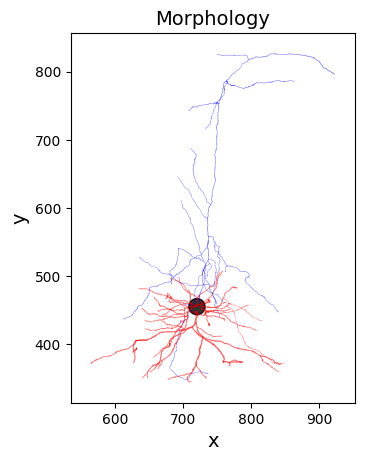

In [11]:
from neurom.core import Morphology
from neurom.view import plot_morph, plot_dendrogram

n = circ.nodes[node_population_post]
m_smooth = Morphology(n.morph.get(0, extension="h5"))

plot_morph(m_smooth)

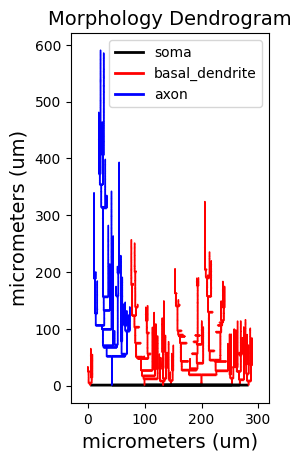

In [12]:
plot_dendrogram(m_smooth)

In [13]:
from neurom import load_morphology_with_spines

m = load_morphology_with_spines(circ.nodes[node_population_post].config["alternate_morphologies"]["h5v1"])
m.spine_table


HDF5 GROUP:0:warning


,afferent_surface_x,afferent_surface_y,afferent_surface_z,afferent_center_x,afferent_center_y,afferent_center_z,spine_id,spine_morphology,spine_length,spine_orientation_vector_x,spine_orientation_vector_y,spine_orientation_vector_z,spine_rotation_x,spine_rotation_y,spine_rotation_z,spine_rotation_w,afferent_section_id,afferent_segment_id,afferent_segment_offset,afferent_section_pos
0,706.615723,480.190277,867.143677,707.504456,480.232452,865.676392,0,864691135970442597,1.391015,0.492664,-0.048354,-0.868875,-0.629803,-0.0,-0.357107,0.689799,3,41,0.070926,0.991690
1,707.367249,480.394135,865.471313,707.504456,480.232452,865.676392,1,864691135970442597,1.116790,-0.642219,0.662741,-0.385135,-0.211196,-0.0,0.352173,0.911795,3,41,0.145047,1.000000
2,708.994019,477.343750,866.872559,708.897949,477.518555,867.070007,2,864691135970442597,0.975117,0.416366,-0.286612,-0.862840,-0.722358,-0.0,-0.348576,0.597239,3,28,0.208066,0.618806
3,709.044739,477.481873,868.536926,708.898010,477.225189,867.363342,3,864691135970442597,0.995025,-0.317314,0.037326,-0.947586,-0.657879,-0.0,0.220301,0.720182,3,25,0.112667,0.546155
4,709.963379,476.437866,868.977051,709.301453,476.344971,867.840088,4,864691135970442597,1.179810,-0.458820,0.044206,-0.887429,-0.614081,-0.0,0.317493,0.722567,3,19,0.070764,0.418479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,745.571472,447.225525,880.309082,745.571472,447.225525,880.309082,2978,864691135970442597,1.936520,-0.160773,-0.837243,0.522662,0.916087,-0.0,0.281792,0.285269,195,76,0.000361,0.566343
2979,744.361206,447.445587,879.758972,744.361206,447.445587,879.758972,2979,864691135970442597,1.259805,-0.246940,-0.937737,-0.244275,-0.692227,-0.0,0.699778,0.176441,195,72,0.000065,0.514745
2980,743.074951,446.571289,879.470459,743.261047,447.665649,879.428894,2980,864691135970442597,0.937058,0.279689,0.956962,0.077445,0.039146,-0.0,-0.141374,0.989182,195,66,0.124546,0.463035
2981,741.861572,448.257996,879.538940,741.940796,448.105713,879.318909,2981,864691135970442597,1.490157,-0.503671,-0.050994,0.862389,0.625970,-0.0,0.365593,0.688842,195,60,0.142220,0.410087


In [14]:
edge = circ.edges[edge_population_name]

afferents = edge.afferent_edges(0, properties=edge.property_names)
display(afferents)
display(afferents.columns)

,@target_node,afferent_center_x,distance,afferent_segment_offset,afferent_surface_y,afferent_surface_x,afferent_segment_id,spine_sharing_id,spine_length,afferent_center_y,@source_node,spine_morphology,afferent_section_pos,spine_psd_id,afferent_section_id,afferent_surface_z,spine_id,afferent_center_z
0,0,708.898010,0.192532,0.112667,477.481873,709.044739,25,3,0.995025,477.225189,0,864691135970442597,0.546155,0,3,868.536926,3,867.363342
1,0,737.980042,0.089676,0.111138,429.631714,736.329712,253,1025,2.581282,429.291779,1,864691135970442597,0.819373,1,97,944.111938,1025,942.140381
2,0,751.357788,-0.134589,0.246964,455.800000,751.304000,126,-1,0.000000,455.695557,2,_NONE,0.526587,-1,93,902.280000,-1,902.295654
3,0,761.817810,0.077174,0.251110,473.851105,761.524414,41,969,0.939574,474.878021,3,864691135970442597,0.146479,2,94,920.026306,969,919.512878
4,0,749.642212,0.111191,0.063745,395.625336,750.810303,19,1360,0.976038,395.184631,4,864691135970442597,0.623291,3,110,871.602478,1360,871.947510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391,0,732.179016,-0.177833,0.341326,454.392000,731.992000,9,-1,0.000000,454.503998,2762,_NONE,0.826793,-1,92,893.640000,-1,893.575989
3392,0,666.331970,0.043726,0.105861,450.368000,666.336000,285,-1,0.000000,450.150970,3186,_NONE,0.841555,-1,181,942.880000,-1,942.641663
3393,0,723.144000,0.268599,0.000000,457.592000,723.144000,0,-1,0.000000,457.592000,1765,_NONE,0.000000,-1,0,882.880000,-1,882.880000
3394,0,681.605225,-0.017833,0.217228,428.104000,681.456000,160,-1,0.000000,428.257263,3187,_NONE,0.528991,-1,141,903.600000,-1,903.499634


Index(['@target_node', 'afferent_center_x', 'distance',
       'afferent_segment_offset', 'afferent_surface_y', 'afferent_surface_x',
       'afferent_segment_id', 'spine_sharing_id', 'spine_length',
       'afferent_center_y', '@source_node', 'spine_morphology',
       'afferent_section_pos', 'spine_psd_id', 'afferent_section_id',
       'afferent_surface_z', 'spine_id', 'afferent_center_z'],
      dtype='object')

In [20]:
is_on_spine = afferents["spine_sharing_id"] != -1
looked_up = m.spine_table.loc[afferents.loc[is_on_spine, "spine_sharing_id"]]

In [21]:
looked_up[looked_up.columns.intersection(afferents.columns)]

,afferent_surface_x,afferent_surface_y,afferent_surface_z,afferent_center_x,afferent_center_y,afferent_center_z,spine_id,spine_morphology,spine_length,afferent_section_id,afferent_segment_id,afferent_segment_offset,afferent_section_pos
3,709.044739,477.481873,868.536926,708.898010,477.225189,867.363342,3,864691135970442597,0.995025,3,25,0.112667,0.546155
1025,736.329712,429.631714,944.111938,737.980042,429.291779,942.140381,1025,864691135970442597,2.581282,97,253,0.111138,0.819373
969,761.524414,473.851105,920.026306,761.817810,474.878021,919.512878,969,864691135970442597,0.939574,94,41,0.251110,0.146479
1360,750.810303,395.625336,871.602478,749.642212,395.184631,871.947510,1360,864691135970442597,0.976038,110,19,0.063745,0.623291
2120,741.046875,471.288696,908.921204,741.317383,471.173920,908.620911,2120,864691135970442597,0.673814,173,123,0.244252,0.329191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,666.906921,474.181183,920.686462,667.053650,473.667755,920.319763,2507,864691135970442597,0.590462,186,95,0.168880,0.310121
466,671.598999,380.058533,839.601624,672.004578,378.607819,838.721436,466,864691135970442597,2.001393,78,64,0.330497,0.795907
2051,745.133850,411.197327,900.772827,745.131348,411.027954,900.552795,2051,864691135970442597,1.095187,170,178,0.000194,0.725419
706,638.683411,454.927155,848.120850,639.731934,453.166779,848.403259,706,864691135970442597,2.487801,86,380,0.136248,1.000000


In [23]:
afferents.loc[is_on_spine, looked_up.columns.intersection(afferents.columns)]

,afferent_surface_x,afferent_surface_y,afferent_surface_z,afferent_center_x,afferent_center_y,afferent_center_z,spine_id,spine_morphology,spine_length,afferent_section_id,afferent_segment_id,afferent_segment_offset,afferent_section_pos
0,709.044739,477.481873,868.536926,708.898010,477.225189,867.363342,3,864691135970442597,0.995025,3,25,0.112667,0.546155
1,736.329712,429.631714,944.111938,737.980042,429.291779,942.140381,1025,864691135970442597,2.581282,97,253,0.111138,0.819373
3,761.524414,473.851105,920.026306,761.817810,474.878021,919.512878,969,864691135970442597,0.939574,94,41,0.251110,0.146479
4,750.810303,395.625336,871.602478,749.642212,395.184631,871.947510,1360,864691135970442597,0.976038,110,19,0.063745,0.623291
5,741.046875,471.288696,908.921204,741.317383,471.173920,908.620911,2120,864691135970442597,0.673814,173,123,0.244252,0.329191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,666.906921,474.181183,920.686462,667.053650,473.667755,920.319763,2507,864691135970442597,0.590462,186,95,0.168880,0.310121
3383,671.598999,380.058533,839.601624,672.004578,378.607819,838.721436,466,864691135970442597,2.001393,78,64,0.330497,0.795907
3384,745.133850,411.197327,900.772827,745.131348,411.027954,900.552795,2051,864691135970442597,1.095187,170,178,0.000194,0.725419
3387,638.683411,454.927155,848.120850,639.731934,453.166779,848.403259,706,864691135970442597,2.487801,86,380,0.136248,1.000000
